<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/04/0404.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## K-means from scratch

We will learn about:

- Initialization
- K-means algorithm
- Inertia

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Example dataset

Text(0.5, 1.0, 'Dataset')

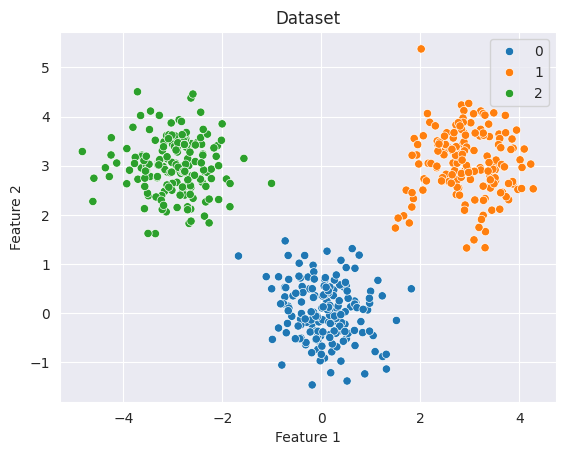

In [ ]:
# Generate the artificial clusters data
#   y_true: cluster identity
X, y_true = make_blobs(
    n_samples=500,
    centers=[[0,0], [3,3], [-3,3]],
    cluster_std=0.60,
    random_state=1 # machine-dependent
) # X: (500,2), y_true: (500,)

# Transform to dataframe
blobs_df  = pd.DataFrame(data=X, columns=['Feature 1', 'Feature 2'])

# Plot the data
sns.scatterplot(
    blobs_df,
    x='Feature 1',
    y='Feature 2',
    hue=y_true,
    palette='tab10'
).set_title('Dataset')

### Initialization

In [ ]:
# Set number of clusters
NUM_CLUSTERS = 3
COLOR_LIST = ['green', 'orange', 'blue']

# Create range of cluster names
cluster_ids = np.arange(NUM_CLUSTERS)

#### Option #1 - random initialization

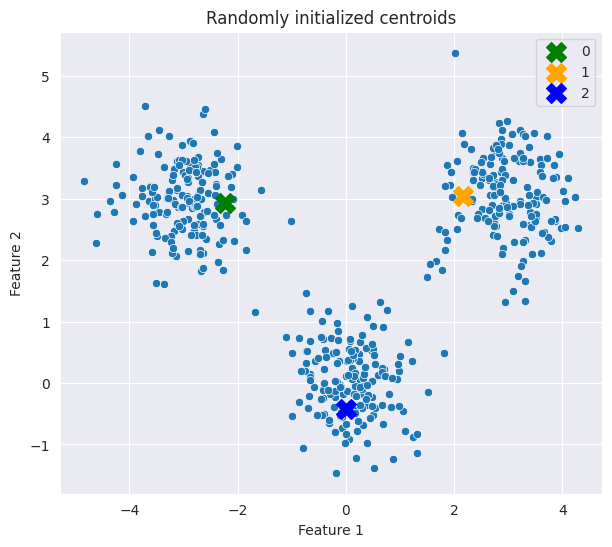

In [ ]:
data_point_idxs = np.arange(X.shape[0])
random_idx = np.random.choice(data_point_idxs, size=NUM_CLUSTERS, replace=False)
clust_centers = X[random_idx] # (3,2)

plt.figure(figsize=(7,6))
sns.scatterplot(blobs_df, x='Feature 1', y='Feature 2')
for clust_id, center in enumerate(clust_centers):
    plt.scatter(
        center[0],
        center[1],
        marker='X',
        s=200,
        color=COLOR_LIST[clust_id],
        label=clust_id
    )
plt.title('Randomly initialized centroids')
plt.legend()

#### Option #2 - k-means++ initialization

In [ ]:
# List containing initial cluster centers
center_list = []

# Select first center
random_idx = np.random.choice(data_point_idxs, size=1)[0]
center_list.append(X[random_idx])

# Calculate distances from the first center
distance = np.linalg.norm(X - center_list[0], axis=1) # (500,)
distance_mtx = np.expand_dims(distance, axis=1) # (500,1)

In [ ]:
# Generate centers
while len(center_list) < NUM_CLUSTERS:
    # For each point, find distance from closest center
    # 此處 centroid 不會重複, 因為選到自己的機率是 0
    dist_from_closest = np.min(distance_mtx, axis=1) # (500,)
    # Transform to probabilities
    selection_probs = dist_from_closest/dist_from_closest.sum()

    # Select new center based on this probabilities
    center_pt_idx = np.random.choice(data_point_idxs, p=selection_probs)

    # Assign new centroid to center list
    center_list.append(X[center_pt_idx])

    # Calculate distance from the new center
    distance = np.linalg.norm(X - X[center_pt_idx], axis=1) # (500,)
    distance_mtx = np.column_stack([distance_mtx, distance]) # finally (500,3)

clust_centers = np.array(center_list)

In [ ]:
# Display cluster centers
clust_centers

array([[ 3.10862325,  3.66430527],
       [-3.30238437,  3.01077353],
       [ 0.83326764, -0.39680655]])

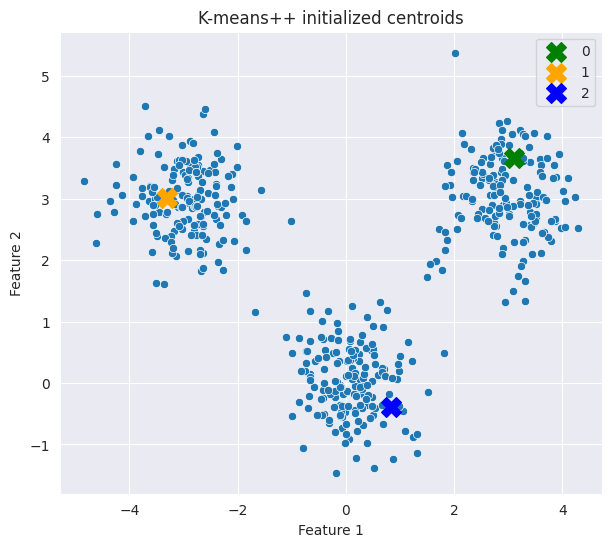

In [ ]:
# Plot k means++ initial cluster centers
plt.figure(figsize=(7,6))
sns.scatterplot(blobs_df, x='Feature 1', y='Feature 2')
color_list = ['green', 'orange', 'blue']
for clust_id, center in enumerate(clust_centers):
    plt.scatter(
        center[0],
        center[1],
        marker='X',
        s=200,
        color=color_list[clust_id],
        label=clust_id
    )
plt.title('K-means++ initialized centroids')
plt.legend()

### K-Means clustering

In [ ]:
# Set MAX_ITER AND TOLERANCE
MAX_ITER = 100 # in case of divergence
TOLERANCE = 1e-4 # identity convergence

# Variable for current iteration
curr_iter = 0

# Iterate until convergence or until MAX_ITER is reached
while True:
    # Each element of this list is np array
    # containing distances from all points
    # to the certain center
    distance_list = []

    # List that will be used to update centers
    new_centers = []

    # Iterate through the centers
    for center in clust_centers:
        # Calculate distance from all the points to
        # the current center and add to the list
        distance_list.append(
            np.linalg.norm(X - center, axis=1)
        ) # finally (3,500)

    # Stack elements of distance list into 2D array
    distance_np = np.column_stack(distance_list) # (500,3)
    # cluster assignment: Find index of row containing minimum element
    point_cluster = np.argmin(distance_np, axis=1) # (500,)

    # centroids update: Update centers
    for cluster_id in cluster_ids:
        new_centers.append(X[point_cluster==cluster_id].mean(axis=0)) # finally (3,2)
    # Transform new centers to np array
    new_centers = np.array(new_centers)

    # Check if loop should be stopped due to MAX_ITER
    if curr_iter >= MAX_ITER:
        break

    # Check if centers have moved
    center_difference = np.linalg.norm(clust_centers - new_centers, axis=1)
    # Check if centers are stable
    if center_difference.max() < TOLERANCE:
        break

    # Make new centers clust_centers
    clust_centers = new_centers

    # Increase iteration counter
    curr_iter += 1 # 其實這應該放在條件判斷之前

Text(0.5, 1.0, 'Final clustering')

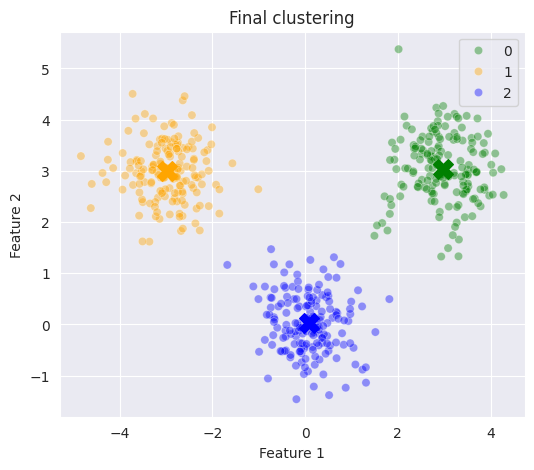

In [ ]:
# Plot final result
plt.figure(figsize=(6, 5))
sns.scatterplot(
    blobs_df,
    x='Feature 1',
    y='Feature 2',
    hue=point_cluster,
    palette=color_list,
    alpha=0.4
)
for clust_id, center in enumerate(clust_centers):
    plt.scatter(
        center[0],
        center[1],
        marker='X',
        s=200,
        color=color_list[clust_id]
    )
plt.title('Final clustering')

#### Inertia

$
I = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
$

In [ ]:
# Initialize inertia to 0
inertia = 0
# Loop going through data points for each cluster
for clust_id in cluster_ids:
    # Calculate inertia portion for current cluster
    clust_points = X[point_cluster == clust_id]
    distance_from_center = np.linalg.norm(clust_points - clust_centers[clust_id], axis=1)

    # Increase inertia
    inertia += np.sum(distance_from_center**2)

In [ ]:
inertia

345.0470655631405